In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import pandas as pd
from keras.callbacks import EarlyStopping
import numpy as np
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.compat.v1.keras.layers import CuDNNLSTM,CuDNNGRU
from tensorflow.keras.layers import BatchNormalization
import os
import datetime
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [ ]:
data_path='/content/drive/My Drive/Colab Notebooks/AI_HW/Dataset/dali.csv'

In [ ]:
dali=pd.read_csv(data_path)

In [ ]:
np_dali=dali.values

In [ ]:
dali_feature=np_dali[:,1:]

In [ ]:
dali_pm25=np_dali[:,:1]

In [ ]:
dali_feature[:6,:]

array([[ 96.  ,   1.08,   3.7 ,   3.4 ,  28.  ,  33.  ,  61.  ,  81.  ,
         14.  , 254.  ,   1.  ],
       [ 92.  ,   1.1 ,   4.1 ,   4.3 ,  28.  ,  32.  ,  61.  ,  79.  ,
         14.  , 134.  ,   1.2 ],
       [ 79.  ,   0.95,   3.6 ,   2.8 ,  21.  ,  24.  ,  45.  ,  82.  ,
         13.  , 239.  ,   0.9 ],
       [ 82.  ,   0.9 ,   3.5 ,   2.4 ,  21.  ,  24.  ,  45.  ,  83.  ,
         12.  , 175.  ,   0.8 ],
       [ 73.  ,   0.8 ,   3.4 ,   2.3 ,  19.  ,  24.  ,  42.  ,  83.  ,
         12.  , 171.  ,   0.8 ],
       [ 63.  ,   0.81,   3.5 ,   2.6 ,  23.  ,  23.  ,  46.  ,  84.  ,
         12.  ,  94.  ,   0.6 ]])

In [ ]:
test=dali.iloc[:8,:]

In [ ]:
look_back=12
pre_time=1
shift=1

In [ ]:
def create_dataset(dataset,look_back=12,pre_time=1,shift=1):
  dataX,dataY=[],[]
  for i in range(0,len(dataset)-look_back-pre_time+1,shift):
    dataX.append(dataset[i:i+look_back,1:])
    dataY.append(dataset[i+look_back:i+look_back+pre_time,:1])
  return np.array(dataX),np.array(dataY)

In [ ]:
def create_testdataset(dataset,look_back=12, shift=1):
  dataX = []
  for i in range(0,dataset.shape[0]-look_back+1,shift):
    dataX.append(dataset[i:i+look_back])
  return np.array(dataX)

In [ ]:
dali_scale=preprocessing.scale(dali.iloc[:,1:])

In [ ]:
DALI = np.hstack([dali_pm25,dali_scale])

In [ ]:
train,test=train_test_split(DALI,test_size=0.15,shuffle=False)

In [ ]:
traindata_x,traindata_y=create_dataset(train,look_back,pre_time, shift)
testdata_x,testdata_y=create_dataset(train,look_back,pre_time, shift=1)

In [ ]:
testdata_y[0]

array([[52.]])

# Model1

In [ ]:
inputs=keras.Input(shape=(look_back,11),name='Input')
lstm_hidden1=CuDNNLSTM(48,return_sequences=True,name='lstm_hidden1')(inputs)
lstm_hidden2=CuDNNLSTM(48,name='lstm_hidden2')(lstm_hidden1)
dence_hidden3=layers.Dense(12,activation='relu',name='dence_hidden3')(lstm_hidden2)
outputs=layers.Dense(1,activation='relu',name='Output')(dence_hidden3)
model=keras.Model(inputs=inputs,outputs=outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 12, 11)]          0         
_________________________________________________________________
lstm_hidden1 (CuDNNLSTM)     (None, 12, 48)            11712     
_________________________________________________________________
lstm_hidden2 (CuDNNLSTM)     (None, 48)                18816     
_________________________________________________________________
dence_hidden3 (Dense)        (None, 12)                588       
_________________________________________________________________
Output (Dense)               (None, 1)                 13        
Total params: 31,129
Trainable params: 31,129
Non-trainable params: 0
_________________________________________________________________


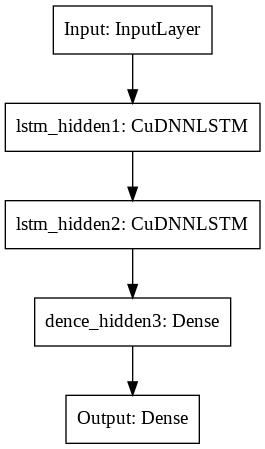

In [ ]:
plot_model(model)

In [ ]:
%load_ext tensorboard

In [ ]:
earlystop=EarlyStopping(patience=10)
logdir=os.path.join("logs",datetime.datetime.now().strftime("%m%Y%d-%H%M%S"))
tensorboard_callback=tf.keras.callbacks.TensorBoard(logdir,histogram_freq=1)
callbacks=[earlystop,tensorboard_callback]

In [ ]:
model.compile(loss='mean_squared_error',optimizer='Adam',metrics=['mse'])
history = model.fit(traindata_x,traindata_y.reshape(traindata_y.shape[0]*traindata_y.shape[1],1), validation_split=0.2, epochs=10000,callbacks=callbacks,batch_size=24)

Epoch 1/10000
885/885 [==============================] - 10s 11ms/step - loss: 199.0806 - mse: 199.0806 - val_loss: 66.9265 - val_mse: 66.9265
Epoch 2/10000
885/885 [==============================] - 9s 10ms/step - loss: 69.4150 - mse: 69.4150 - val_loss: 57.1161 - val_mse: 57.1161
Epoch 3/10000
885/885 [==============================] - 9s 10ms/step - loss: 61.6079 - mse: 61.6079 - val_loss: 49.7527 - val_mse: 49.7527
Epoch 4/10000
885/885 [==============================] - 9s 10ms/step - loss: 57.1061 - mse: 57.1061 - val_loss: 61.8610 - val_mse: 61.8610
Epoch 5/10000
885/885 [==============================] - 9s 10ms/step - loss: 53.3228 - mse: 53.3228 - val_loss: 62.7687 - val_mse: 62.7687
Epoch 6/10000
885/885 [==============================] - 9s 10ms/step - loss: 49.8579 - mse: 49.8579 - val_loss: 69.0689 - val_mse: 69.0689
Epoch 7/10000
885/885 [==============================] - 9s 10ms/step - loss: 46.8783 - mse: 46.8783 - val_loss: 66.7670 - val_mse: 66.7670
Epoch 8/10000
885

In [ ]:
#%tensorboard --logdir logs

In [ ]:
pre_dataframe=pd.DataFrame(model.predict(testdata_x).reshape(-1),columns=['pre'])

In [ ]:
pre_dataframe

,pre
0,49.519230
1,46.115864
2,41.718269
3,46.778812
4,44.329662
...,...
26543,16.519283
26544,11.561484
26545,13.785773
26546,17.059502


In [ ]:
compare=pd.concat([pre_dataframe,pd.DataFrame(testdata_y.reshape(-1),columns=['act'])],axis=1)

In [ ]:
compare

,pre,act
0,49.519230,52.0
1,46.115864,44.0
2,41.718269,47.0
3,46.778812,41.0
4,44.329662,43.0
...,...,...
26543,16.519283,6.0
26544,11.561484,6.0
26545,13.785773,5.0
26546,17.059502,8.0


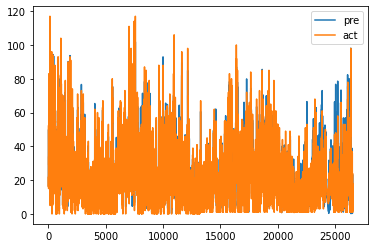

In [ ]:
compare.plot()

In [ ]:
rmse = mean_squared_error(pre_dataframe,pd.DataFrame(testdata_y.reshape(-1)),squared=False)
rmse

6.2388770704200205

# Model2

Model2

In [ ]:
inputs = keras.Input(shape=(look_back,11), name='Input')
# inputs = keras.Input(shape=(look_back,12), name='Input') #Input include pm2.5
lstm_hidden1 = CuDNNLSTM(48, return_sequences=True, name='lstm_hidden1')(inputs)
lstm_hidden2 = CuDNNLSTM(48,return_sequences=True,name='lstm_hidden2')(lstm_hidden1)
lstm_hidden3 = CuDNNLSTM(48,return_sequences=True,name='lstm_hidden3')(lstm_hidden2)
lstm_hidden4 = CuDNNLSTM(48,return_sequences=True,name='lstm_hidden4')(lstm_hidden3)
lstm_hidden5 = CuDNNLSTM(48,name='lstm_hidden5')(lstm_hidden4)
dence_hidden1 = layers.Dense(12,activation='elu', name='dence_hidden1')(lstm_hidden5)
dence_hidden2 = layers.Dense(12,activation='elu', name='dence_hidden2')(dence_hidden1)
dence_hidden3 = layers.Dense(12,activation='elu', name='dence_hidden3')(dence_hidden2)
outputs = layers.Dense(1, activation='elu', name='Output')(dence_hidden3)
model2 = keras.Model(inputs=inputs, outputs=outputs)

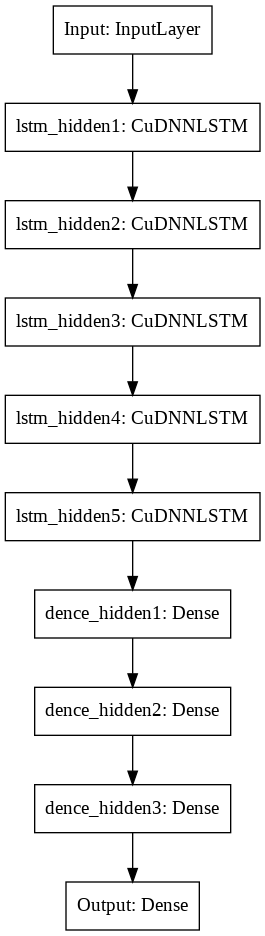

In [ ]:
plot_model(model2)

In [ ]:
model2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 12, 11)]          0         
_________________________________________________________________
lstm_hidden1 (CuDNNLSTM)     (None, 12, 48)            11712     
_________________________________________________________________
lstm_hidden2 (CuDNNLSTM)     (None, 12, 48)            18816     
_________________________________________________________________
lstm_hidden3 (CuDNNLSTM)     (None, 12, 48)            18816     
_________________________________________________________________
lstm_hidden4 (CuDNNLSTM)     (None, 12, 48)            18816     
_________________________________________________________________
lstm_hidden5 (CuDNNLSTM)     (None, 48)                18816     
_________________________________________________________________
dence_hidden1 (Dense)        (None, 12)                588 

In [ ]:
model2.compile(loss='mean_squared_error',optimizer='Adam',metrics=['mse'])
history = model2.fit(traindata_x,traindata_y.reshape(26548,1), validation_split=0.2, epochs=10000,callbacks=callbacks,batch_size=24)

Epoch 1/10000
885/885 [==============================] - 15s 17ms/step - loss: 231.9051 - mse: 231.9051 - val_loss: 50.1001 - val_mse: 50.1001
Epoch 2/10000
885/885 [==============================] - 10s 11ms/step - loss: 69.7742 - mse: 69.7742 - val_loss: 57.7541 - val_mse: 57.7541
Epoch 3/10000
885/885 [==============================] - 10s 11ms/step - loss: 63.2188 - mse: 63.2188 - val_loss: 58.0520 - val_mse: 58.0520
Epoch 4/10000
885/885 [==============================] - 10s 11ms/step - loss: 58.2732 - mse: 58.2732 - val_loss: 56.6624 - val_mse: 56.6624
Epoch 5/10000
885/885 [==============================] - 10s 11ms/step - loss: 54.2663 - mse: 54.2663 - val_loss: 58.3146 - val_mse: 58.3146
Epoch 6/10000
885/885 [==============================] - 10s 11ms/step - loss: 51.1933 - mse: 51.1933 - val_loss: 66.1076 - val_mse: 66.1076
Epoch 7/10000
885/885 [==============================] - 10s 11ms/step - loss: 47.7099 - mse: 47.7099 - val_loss: 68.2365 - val_mse: 68.2365
Epoch 8/100

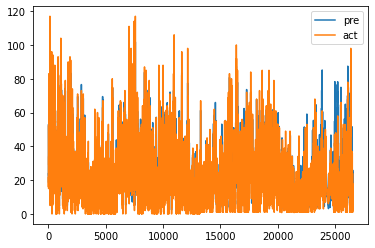

In [ ]:
pre_dataframe=pd.DataFrame(model2.predict(testdata_x),columns=['pre'])
compare=pd.concat([pre_dataframe,pd.DataFrame(testdata_y.reshape(-1),columns=['act'])],axis=1)
compare.plot()

In [ ]:
rmse = mean_squared_error(pre_dataframe,pd.DataFrame(testdata_y.reshape(-1)),squared=False)
rmse

6.258527132436798

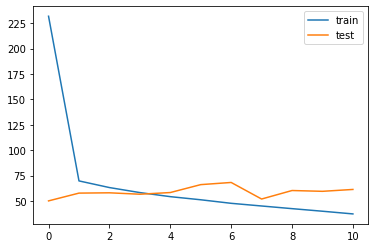

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Model3

**Model3**

In [ ]:
inputs = keras.Input(shape=(look_back,11), name='Input')
lstm_hidden1 = CuDNNLSTM(48, return_sequences=True, name='lstm_hidden1')(inputs)
drop1 = layers.Dropout(0.2)(lstm_hidden1)
lstm_hidden2 = CuDNNLSTM(48, name='lstm_hidden2')(lstm_hidden1)
drop2 = layers.Dropout(0.2)(lstm_hidden2)
batch_normalization1 = BatchNormalization()(lstm_hidden2)
dence_hidden3 = layers.Dense(12,activation='relu',name='dence_hidden3')(batch_normalization1)
dence_hidden4 = layers.Dense(12,activation='relu', name='dence_hidden4')(dence_hidden3)
outputs = layers.Dense(1, activation='relu', name='Output')(dence_hidden4)
model3 = keras.Model(inputs=inputs, outputs=outputs)

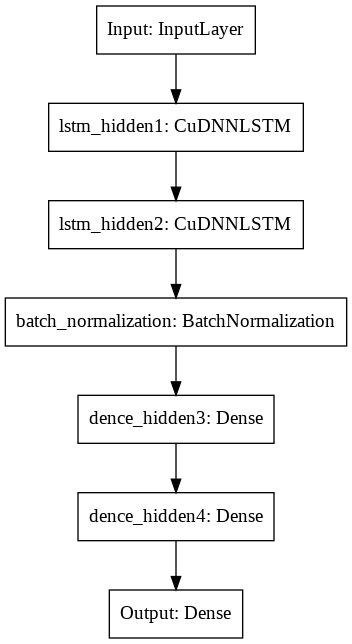

In [ ]:
plot_model(model3)

In [ ]:
model3.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 12, 11)]          0         
_________________________________________________________________
lstm_hidden1 (CuDNNLSTM)     (None, 12, 48)            11712     
_________________________________________________________________
lstm_hidden2 (CuDNNLSTM)     (None, 48)                18816     
_________________________________________________________________
batch_normalization (BatchNo (None, 48)                192       
_________________________________________________________________
dence_hidden3 (Dense)        (None, 12)                588       
_________________________________________________________________
dence_hidden4 (Dense)        (None, 12)                156       
_________________________________________________________________
Output (Dense)               (None, 1)                 13  

In [ ]:
model3.compile(loss='mean_squared_error',optimizer='Adam',metrics=['mse'])
history = model3.fit(traindata_x,traindata_y.reshape(26548,1), validation_split=0.2, epochs=10000,callbacks=callbacks,batch_size=24)
result = model3.evaluate(traindata_x,traindata_y)
result[1]

Epoch 1/10000
885/885 [==============================] - 8s 9ms/step - loss: 165.1760 - mse: 165.1760 - val_loss: 52.4212 - val_mse: 52.4212
Epoch 2/10000
885/885 [==============================] - 6s 7ms/step - loss: 82.7273 - mse: 82.7273 - val_loss: 65.7423 - val_mse: 65.7423
Epoch 3/10000
885/885 [==============================] - 6s 7ms/step - loss: 71.2977 - mse: 71.2977 - val_loss: 88.8673 - val_mse: 88.8673
Epoch 4/10000
885/885 [==============================] - 6s 7ms/step - loss: 66.4597 - mse: 66.4597 - val_loss: 61.7955 - val_mse: 61.7955
Epoch 5/10000
885/885 [==============================] - 6s 7ms/step - loss: 62.0026 - mse: 62.0026 - val_loss: 74.1783 - val_mse: 74.1783
Epoch 6/10000
885/885 [==============================] - 6s 7ms/step - loss: 58.0131 - mse: 58.0131 - val_loss: 63.9309 - val_mse: 63.9309
Epoch 7/10000
885/885 [==============================] - 6s 7ms/step - loss: 55.1627 - mse: 55.1627 - val_loss: 72.3783 - val_mse: 72.3783
Epoch 8/10000
885/885 [==

45.567726135253906

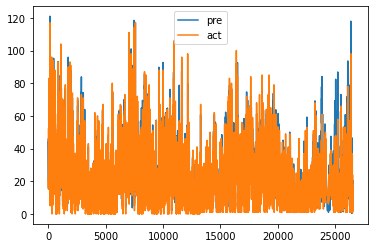

In [ ]:
pre_dataframe=pd.DataFrame(model3.predict(testdata_x),columns=['pre'])
compare=pd.concat([pre_dataframe,pd.DataFrame(testdata_y.reshape(-1),columns=['act'])],axis=1)
compare.plot()

In [ ]:
rmse = mean_squared_error(pre_dataframe,pd.DataFrame(testdata_y.reshape(-1)),squared=False)
rmse

6.750388780489759

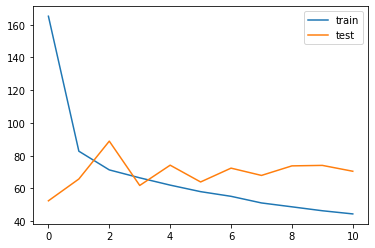

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Model4

In [ ]:
inputs=keras.Input(shape=(look_back,11),name='Input')
gru_hidden1=CuDNNGRU(48,return_sequences=True,name='gru_hidden1')(inputs)
gru_hidden2=CuDNNGRU(48,name='gru_hidden2')(gru_hidden1)
dence_hidden3=layers.Dense(12,activation='relu',name='dence_hidden3')(gru_hidden2)
outputs=layers.Dense(1,activation='relu',name='Output')(dence_hidden3)
model4 = keras.Model(inputs=inputs,outputs=outputs)

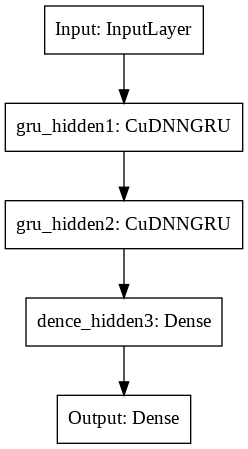

In [ ]:
plot_model(model4)

In [ ]:
model4.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 12, 11)]          0         
_________________________________________________________________
gru_hidden1 (CuDNNGRU)       (None, 12, 48)            8784      
_________________________________________________________________
gru_hidden2 (CuDNNGRU)       (None, 48)                14112     
_________________________________________________________________
dence_hidden3 (Dense)        (None, 12)                588       
_________________________________________________________________
Output (Dense)               (None, 1)                 13        
Total params: 23,497
Trainable params: 23,497
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model4.compile(loss='mean_squared_error',optimizer='Adam',metrics=['mse'])
history = model4.fit(traindata_x,traindata_y.reshape(26548,1), validation_split=0.2, epochs=10000,callbacks=callbacks,batch_size=24)

Epoch 1/10000
885/885 [==============================] - 14s 16ms/step - loss: 171.4366 - mse: 171.4366 - val_loss: 53.0899 - val_mse: 53.0899
Epoch 2/10000
885/885 [==============================] - 6s 7ms/step - loss: 68.2911 - mse: 68.2911 - val_loss: 61.2098 - val_mse: 61.2098
Epoch 3/10000
885/885 [==============================] - 6s 6ms/step - loss: 63.3692 - mse: 63.3692 - val_loss: 61.8695 - val_mse: 61.8695
Epoch 4/10000
885/885 [==============================] - 6s 6ms/step - loss: 60.2997 - mse: 60.2997 - val_loss: 50.1237 - val_mse: 50.1237
Epoch 5/10000
885/885 [==============================] - 6s 6ms/step - loss: 57.2628 - mse: 57.2628 - val_loss: 48.2073 - val_mse: 48.2073
Epoch 6/10000
885/885 [==============================] - 6s 6ms/step - loss: 54.3526 - mse: 54.3526 - val_loss: 65.0284 - val_mse: 65.0284
Epoch 7/10000
885/885 [==============================] - 6s 6ms/step - loss: 51.2400 - mse: 51.2400 - val_loss: 63.5038 - val_mse: 63.5038
Epoch 8/10000
885/885 [

In [ ]:
pre_dataframe=pd.DataFrame(model.predict(testdata_x).reshape(-1),columns=['pre'])

In [ ]:
compare=pd.concat([pre_dataframe,pd.DataFrame(testdata_y.reshape(-1),columns=['act'])],axis=1)

In [ ]:
compare

,pre,act
0,47.453526,52.0
1,43.572758,44.0
2,42.418575,47.0
3,45.871494,41.0
4,44.196850,43.0
...,...,...
26543,19.300505,6.0
26544,15.962386,6.0
26545,19.648438,5.0
26546,16.641350,8.0


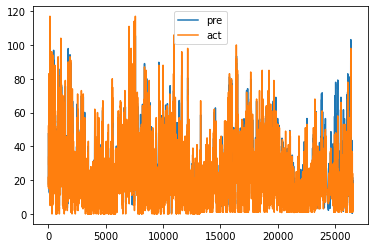

In [ ]:
compare.plot()

In [ ]:
rmse = mean_squared_error(pre_dataframe,pd.DataFrame(testdata_y.reshape(-1)),squared=False)
rmse

6.444750315728566

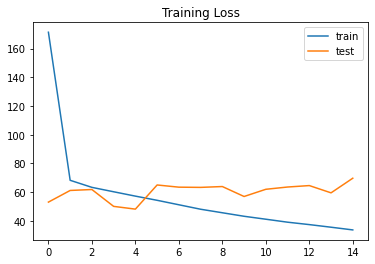

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title("Training Loss")
plt.legend()
plt.show()